In [14]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# 파라미터 정의
def param_squeezing(pump, b_freq_p, a_freq, b_freq, b_loss, J0):
    beta = pump/b_freq_p
    rp = (1/4) * np.log((1 + beta) / (1 - beta))
    bs_freq = np.sqrt(1-beta**2)*b_freq_p + b_freq - b_freq_p
    a_freq_bs = a_freq - bs_freq
    noise = (2 * np.sinh(rp)**2 * b_loss)
    Js = np.cosh(rp)*J0

    return beta, rp, bs_freq, a_freq_bs, noise, Js

def param_reproduce(kappa_ext, delta, J0, b_freq_p, pump):
    kappa = 1
    a_freq = delta
    b_freq = delta
    a_loss = kappa
    b_loss = kappa
    ex1 = kappa_ext
    ex2 = kappa_ext

    param_squeeze = param_squeezing(pump, b_freq_p, a_freq, b_freq, b_loss, J0)

    return a_freq, b_freq, a_loss, b_loss, ex1, ex2, J0, param_squeeze

In [15]:
def forward_system(t, y, params, AMP, is_noise):
    a_freq, b_freq, a_loss, b_loss, ex1, ex2, J0, param_squeeze = params
    beta, rp, bs_freq, a_freq_bs, noise, Js = param_squeeze
    ain = AMP
    ab_loss = a_loss+b_loss

    if not is_noise:
        noise = 0

    a = y[0] + 1j * y[1]
    bs = y[2] + 1j * y[3]
    a_dagger_bs = y[4] + 1j * y[5]
    a_dagger_a = y[6]
    bs_dagger_bs = y[7]

    # 시간 미분 계산
    da = -(1j * a_freq + a_loss) * a + np.sqrt(2 * ex1) * ain - 1j * Js * bs
    dbs = -(1j * bs_freq + b_loss) * bs - 1j * Js * a
    d_a_bs = (1j * a_freq_bs - ab_loss) * a_dagger_bs + np.sqrt(2 * ex1) * np.conj(ain) * bs - 1j * Js * (a_dagger_a-bs_dagger_bs)
    ab_imag = (a_dagger_bs - np.conj(a_dagger_bs))
    d_bs_bs = 1j * Js * ab_imag - 2 * b_loss * bs_dagger_bs + noise
    d_aa = -1j * Js * ab_imag + np.sqrt(2 * ex1) * (ain * np.conj(a) + np.conj(ain) * a) - 2 * a_loss * a_dagger_a

    return [
        da.real, da.imag,
        dbs.real, dbs.imag,
        d_a_bs.real, d_a_bs.imag,
        d_aa.real, d_bs_bs.real
    ]

def backward_system(t, y, params, AMP):
    a_freq, b_freq, a_loss, b_loss, ex1, ex2, J0, _ = params
    ain = AMP
    ab_loss = a_loss+b_loss

    a = y[0] + 1j * y[1]
    bs = y[2] + 1j * y[3]
    a_dagger_bs = y[4] + 1j * y[5]
    a_dagger_a = y[6]
    bs_dagger_bs = y[7]

    # 시간 미분 계산
    da = -(1j * a_freq + a_loss) * a + np.sqrt(2 * ex1) * ain - 1j * J0 * bs
    dbs = -(1j * b_freq + b_loss) * bs - 1j * J0 * a
    d_a_bs = (1j * (a_freq-b_freq) - ab_loss) * a_dagger_bs + np.sqrt(2 * ex1) * np.conj(ain) * bs - 1j * J0 * (a_dagger_a-bs_dagger_bs)
    ab_imag = (a_dagger_bs - np.conj(a_dagger_bs))
    d_bs_bs = 1j * J0 * ab_imag - 2 * b_loss * bs_dagger_bs
    d_aa = -1j * J0 * ab_imag + np.sqrt(2 * ex1) * (ain * np.conj(a) + np.conj(ain) * a).real - 2 * a_loss * a_dagger_a

    return [
        da.real, da.imag,
        dbs.real, dbs.imag,
        d_a_bs.real, d_a_bs.imag,
        d_aa.real, d_bs_bs.real
    ]




In [16]:
def solve_classic(params, AMP, is_forward, is_noise=True):
    y0 = np.zeros(8)
    t_span = (0, 10)
    t_eval = np.linspace(*t_span, 1000)
    if is_forward:
        sol = solve_ivp(forward_system, t_span, y0, args=(params, AMP, is_noise), t_eval=t_eval)
    else:
        sol = solve_ivp(backward_system, t_span, y0, args=(params, AMP), t_eval=t_eval)

    _,_,_,_,ex1,ex2,_,_ = params
    T12=1-np.sqrt(2 * ex1)*(sol.y[0][-1]*2)/AMP + 2*ex1*sol.y[6][-1]/AMP**2
    T14=2 * ex2 * sol.y[7][-1] / AMP**2

    return sol, T12, T14

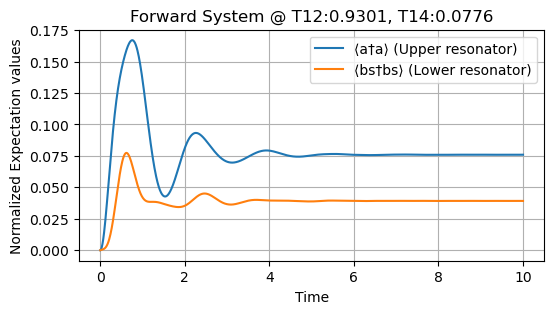

In [46]:
AMP = 10
sol, T12, T14 = solve_classic(
    param_reproduce(
        kappa_ext=0.99,
        delta=2.62,
        J0=2.8,
        b_freq_p=15,
        pump=13
    ),
    AMP,
    True,
    is_noise = True
)
# 결과 시각화
plt.figure(figsize=(6, 3))
plt.plot(sol.t, sol.y[6]/AMP**2, label="⟨a†a⟩ (Upper resonator)")
plt.plot(sol.t, sol.y[7]/AMP**2, label="⟨bs†bs⟩ (Lower resonator)")
plt.xlabel("Time")
plt.ylabel("Normalized Expectation values")
plt.title("Forward System @ "+f"T12:{T12:.4f}, T14:{T14:.4f}")
plt.legend()
plt.grid(True)
plt.savefig('figs/forward_noise.png')
plt.show()


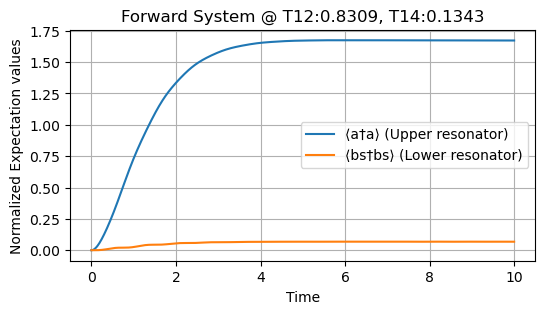

In [18]:
AMP = 10
sol, T12, T14 = solve_classic(
    param_reproduce(
        kappa_ext=0.99,
        delta=0,
        J0=0.99,
        b_freq_p=10.3,
        pump=10
    ),
    AMP,
    True,
    is_noise = False
)
# 결과 시각화
plt.figure(figsize=(6, 3))
plt.plot(sol.t, sol.y[6]/AMP**2, label="⟨a†a⟩ (Upper resonator)")
plt.plot(sol.t, sol.y[7]/AMP**2, label="⟨bs†bs⟩ (Lower resonator)")
plt.xlabel("Time")
plt.ylabel("Normalized Expectation values")
plt.title("Forward System @ "+f"T12:{T12:.4f}, T14:{T14:.4f}")
plt.legend()
plt.grid(True)
plt.savefig('figs/forward_sv.png')
plt.show()


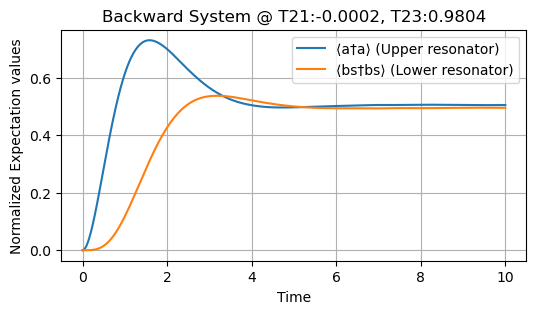

In [19]:
AMP = 10
sol, T12, T14 = solve_classic(
    param_reproduce(
        kappa_ext=0.99,
        delta=0,
        J0=0.99,
        b_freq_p=10.3,
        pump=10
    ),
    AMP,
    False
)
# 결과 시각화
plt.figure(figsize=(6, 3))
plt.plot(sol.t, sol.y[6]/AMP**2, label="⟨a†a⟩ (Upper resonator)")
plt.plot(sol.t, sol.y[7]/AMP**2, label="⟨bs†bs⟩ (Lower resonator)")
plt.xlabel("Time")
plt.ylabel("Normalized Expectation values")
plt.title("Backward System @ "+f"T21:{T12:.4f}, T23:{T14:.4f}")
plt.legend()
plt.grid(True)
plt.savefig('figs/backward.png')
plt.show()


In [35]:
def calc_theory(params, AMP, is_noise = True):
    a_freq, b_freq, a_loss, b_loss, ex1, ex2, J0, param_squeeze = params
    beta, rp, bs_freq, a_freq_bs, noise, Js = param_squeeze

    # Extract parameters
    kappa_a = a_loss
    kappa_b = b_loss
    kappa_ex1 = ex1
    kappa_ex2 = ex2
    Delta_a = a_freq
    Delta_b_s = bs_freq
    Delta_b_0 = b_freq
    alpha_inj = AMP

    # Calculate common terms
    # For forward case (s)
    Delta_ab_s = a_freq_bs
    Qs = Js**2 * (kappa_a + kappa_b)**2 + kappa_a * kappa_b * ((kappa_a + kappa_b)**2 + Delta_ab_s**2)
    N_noise = kappa_b * (kappa_a + kappa_b) * np.sinh(rp)**2 * Js**2 / Qs
    if not is_noise:
        N_noise =0
    # Gx calculation
    Gs = (Js**4 + 2 * Js**2 * (kappa_a * kappa_b - Delta_a * Delta_b_s) +
          (kappa_a**2 + Delta_a**2) * (kappa_b**2 + Delta_b_s**2))
    G0 = (J0**4 + 2 * J0**2 * (kappa_a * kappa_b - Delta_a * Delta_b_0) +
          (kappa_a**2 + Delta_a**2) * (kappa_b**2 + Delta_b_0**2))

    # zeta calculation
    zeta_s = kappa_a * kappa_b - 2 * kappa_b * kappa_ex1 - Delta_a * Delta_b_s
    zeta_0 = kappa_a * kappa_b - 2 * kappa_b * kappa_ex1 - Delta_a * Delta_b_0

    # Lambda calculation
    Lambda_s = ((kappa_a - 2 * kappa_ex1)**2 + Delta_a**2) * (kappa_b**2 + Delta_b_s**2)
    Lambda_0 = ((kappa_a - 2 * kappa_ex1)**2 + Delta_a**2) * (kappa_b**2 + Delta_b_0**2)

    # Calculate transmissions
    T12 = (Js**4 + 2 * zeta_s * Js**2 + Lambda_s) / Gs + 2 * kappa_ex1 * N_noise / np.abs(alpha_inj)**2
    T21 = (J0**4 + 2 * zeta_0 * J0**2 + Lambda_0) / G0
    T23 = 4 * kappa_ex1 * kappa_ex2 * J0**2 / G0

    # Calculate isolation ratio in dB
    eta = 10 * np.log10(T12 / T21)

    return T12, T21, T23, eta

AMP = 10
T12, T21, T23, eta = calc_theory(
    param_reproduce(
        kappa_ext=0.99,
        delta=0,
        J0=0.99,
        b_freq_p=10.3,
        pump=10
    ),
    AMP,
)

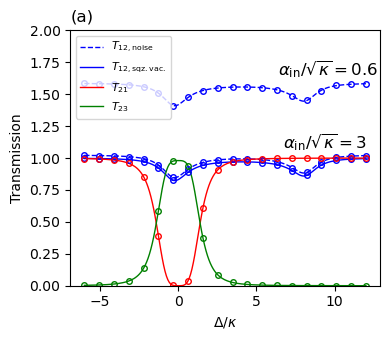

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# 예시 데이터 (사용자 데이터로 대체)
x = np.linspace(-6, 12, 20)
T12_sqzc = np.copy(x)
T12_06c = np.copy(x)
T12c = np.copy(x)
T21c = np.copy(x)
T23c = np.copy(x)
xx = np.linspace(-6, 12, 200)
T12_sqz = np.copy(xx)
T12_06 = np.copy(xx)
T12 = np.copy(xx)
T21 = np.copy(xx)
T23 = np.copy(xx)
for ii, delta in enumerate(xx):
    T12[ii], T21[ii], T23[ii], _ = calc_theory(
        param_reproduce(
            kappa_ext=0.99,
            delta=delta,
            J0=0.99,
            b_freq_p=10.3,
            pump=10
        ),
        3,
    )
for ii, delta in enumerate(xx):
    T12_06[ii], _, _, _ = calc_theory(
        param_reproduce(
            kappa_ext=0.99,
            delta=delta,
            J0=0.99,
            b_freq_p=10.3,
            pump=10
        ),
        0.6,
    )
for ii, delta in enumerate(xx):
    T12_sqz[ii], _, _, _ = calc_theory(
        param_reproduce(
            kappa_ext=0.99,
            delta=delta,
            J0=0.99,
            b_freq_p=10.3,
            pump=10
        ),
        0.6,
        is_noise=False
    )
for ii, delta in enumerate(x):
    _, T12c[ii], _ = solve_classic(
        param_reproduce(
            kappa_ext=0.99,
            delta=delta,
            J0=0.99,
            b_freq_p=10.3,
            pump=10
        ),
        3,
        True,
    )
for ii, delta in enumerate(x):
    _, T12_06c[ii], _ = solve_classic(
        param_reproduce(
            kappa_ext=0.99,
            delta=delta,
            J0=0.99,
            b_freq_p=10.3,
            pump=10
        ),
        0.6,
        True,
    )
for ii, delta in enumerate(x):
    _, T21c[ii], T23c[ii] = solve_classic(
        param_reproduce(
            kappa_ext=0.99,
            delta=delta,
            J0=0.99,
            b_freq_p=10.3,
            pump=10
        ),
        3,
        False,
    )
for ii, delta in enumerate(x):
    _, T12_sqzc[ii], _ = solve_classic(
        param_reproduce(
            kappa_ext=0.99,
            delta=delta,
            J0=0.99,
            b_freq_p=10.3,
            pump=10
        ),
        0.6,
        True,
        is_noise=False
    )

# 색상 및 스타일
colors = {"T12_noise": "blue", "T12": "blue", "T21": "red", "T23": "green"}
linestyles = {"T12_noise": "--", "T12": "--", "T21": "-", "T23": "-"}

# 그래프 (a)
plt.figure(figsize=(4, 3.5))
plt.plot(xx, T12, color=colors["T12"], label=r'$T_{12, \mathrm{noise}}$', linestyle=linestyles["T12"], linewidth=1)
plt.plot(xx, T12_sqz, color=colors["T12"], label=r'$T_{12, \mathrm{sqz.vac.}}$', linestyle="-", linewidth=1)
plt.plot(xx, T12_06, color=colors["T12_noise"], linestyle=linestyles["T12_noise"], linewidth=1)
plt.plot(xx, T21, color=colors["T21"], label=r'$T_{21}$', linestyle=linestyles["T21"], linewidth=1)
plt.plot(xx, T23, color=colors["T23"], label=r'$T_{23}$', linestyle=linestyles["T23"], linewidth=1)


plt.plot(x, T12_sqzc, 'o', color=colors["T12"], markersize=4, markerfacecolor='none')
plt.plot(x, T12_06c, 'o', color=colors["T12_noise"], markersize=4, markerfacecolor='none')
plt.plot(x, T12c, 'o', color=colors["T12"], markersize=4, markerfacecolor='none')
plt.plot(x, T21c, 'o', color=colors["T21"], markersize=4, markerfacecolor='none')
plt.plot(x, T23c, 'o', color=colors["T23"], markersize=4, markerfacecolor='none')
plt.xlabel(r'$\Delta/\kappa$')

plt.text(6.4, 1.65, r'$\alpha_{\mathrm{in}}/\sqrt{\kappa} = 0.6$', fontsize=12)
plt.text(6.7, 1.08, r'$\alpha_{\mathrm{in}}/\sqrt{\kappa} = 3$', fontsize=12)

plt.ylabel("Transmission")
plt.ylim(0, 2)
plt.title("(a)", loc="left")
plt.legend(loc="upper left", fontsize=8)
plt.tight_layout()
plt.savefig("transmission_NMS.png", dpi=300)
plt.show()


In [10]:
T12

0.8327096343194239

In [11]:
T21

2.5505024779968826e-09

In [12]:
T23

0.9800010074994949

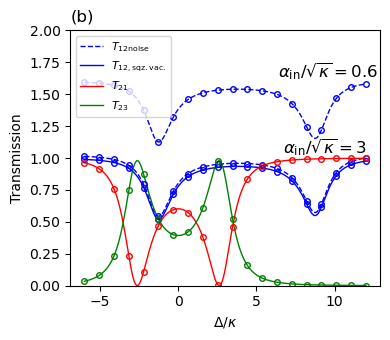

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# 예시 데이터 (사용자 데이터로 대체)
x = np.linspace(-6, 12, 20)
T12_sqzc = np.copy(x)
T12_06c = np.copy(x)
T12c = np.copy(x)
T21c = np.copy(x)
T23c = np.copy(x)
xx = np.linspace(-6, 12, 200)
T12_sqz = np.copy(xx)
T12_06 = np.copy(xx)
T12 = np.copy(xx)
T21 = np.copy(xx)
T23 = np.copy(xx)
for ii, delta in enumerate(xx):
    T12[ii], T21[ii], T23[ii], _ = calc_theory(
        param_reproduce(
            kappa_ext=0.99,
            delta=delta,
            J0=2.8,
            b_freq_p=15,
            pump=13
        ),
        3,
    )
for ii, delta in enumerate(xx):
    T12_06[ii], _, _, _ = calc_theory(
        param_reproduce(
            kappa_ext=0.99,
            delta=delta,
            J0=2.8,
            b_freq_p=15,
            pump=13
        ),
        0.6,
    )
for ii, delta in enumerate(xx):
    T12_sqz[ii], _, _, _ = calc_theory(
        param_reproduce(
            kappa_ext=0.99,
            delta=delta,
            J0=2.8,
            b_freq_p=15,
            pump=13
        ),
        0.6,
        is_noise=False
    )
for ii, delta in enumerate(x):
    _, T12c[ii], _ = solve_classic(
        param_reproduce(
            kappa_ext=0.99,
            delta=delta,
            J0=2.8,
            b_freq_p=15,
            pump=13
        ),
        3,
        True,
    )
for ii, delta in enumerate(x):
    _, T12_06c[ii], _ = solve_classic(
        param_reproduce(
            kappa_ext=0.99,
            delta=delta,
            J0=2.8,
            b_freq_p=15,
            pump=13
        ),
        0.6,
        True,
    )
for ii, delta in enumerate(x):
    _, T21c[ii], T23c[ii] = solve_classic(
        param_reproduce(
            kappa_ext=0.99,
            delta=delta,
            J0=2.8,
            b_freq_p=15,
            pump=13
        ),
        3,
        False,
    )
for ii, delta in enumerate(x):
    _, T12_sqzc[ii], _ = solve_classic(
        param_reproduce(
            kappa_ext=0.99,
            delta=delta,
            J0=2.8,
            b_freq_p=15,
            pump=13
        ),
        0.6,
        True,
        is_noise=False
    )

# 색상 및 스타일
colors = {"T12_noise": "blue", "T12": "blue", "T21": "red", "T23": "green"}
linestyles = {"T12_noise": "--", "T12": "--", "T21": "-", "T23": "-"}

# 그래프 (a)
plt.figure(figsize=(4, 3.5))
plt.plot(xx, T12, color=colors["T12"], label=r'$T_{12, \mathrm{noise}}$', linestyle=linestyles["T12"], linewidth=1)
plt.plot(xx, T12_sqz, color=colors["T12"], label=r'$T_{12, \mathrm{sqz.vac.}}$', linestyle="-", linewidth=1)
plt.plot(xx, T12_06, color=colors["T12_noise"], linestyle=linestyles["T12_noise"], linewidth=1)
plt.plot(xx, T21, color=colors["T21"], label=r'$T_{21}$', linestyle=linestyles["T21"], linewidth=1)
plt.plot(xx, T23, color=colors["T23"], label=r'$T_{23}$', linestyle=linestyles["T23"], linewidth=1)


plt.plot(x, T12_sqzc, 'o', color=colors["T12"], markersize=4, markerfacecolor='none')
plt.plot(x, T12_06c, 'o', color=colors["T12_noise"], markersize=4, markerfacecolor='none')
plt.plot(x, T12c, 'o', color=colors["T12"], markersize=4, markerfacecolor='none')
plt.plot(x, T21c, 'o', color=colors["T21"], markersize=4, markerfacecolor='none')
plt.plot(x, T23c, 'o', color=colors["T23"], markersize=4, markerfacecolor='none')
plt.xlabel(r'$\Delta/\kappa$')

plt.text(6.4, 1.63, r'$\alpha_{\mathrm{in}}/\sqrt{\kappa} = 0.6$', fontsize=12)
plt.text(6.7, 1.04, r'$\alpha_{\mathrm{in}}/\sqrt{\kappa} = 3$', fontsize=12)

plt.ylabel("Transmission")
plt.ylim(0, 2)
plt.title("(b)", loc="left")
plt.legend(loc="upper left", fontsize=8)
plt.tight_layout()
plt.savefig("transmission_MRS.png", dpi=300)
plt.show()
